In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

import matplotlib.pyplot as plt

import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor


In [2]:
# Data download
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=True)



h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


In [3]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Cal dates   : 2005-07-01 00:00:00 --- 2006-12-01 00:00:00  (n=18)
Test dates  : 2007-01-01 00:00:00 --- 2008-06-01 00:00:00  (n=18)


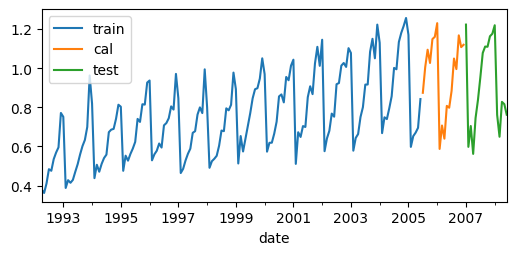

In [4]:
# ==============================================================================
steps = 18
data_train = data[:-steps]
data_train, data_cal = data_train[0:-steps], data_train[-steps:]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)

print(
    f"Cal dates   : {data_cal.index.min()} --- "
    f"{data_cal.index.max()}  (n={len(data_cal)})"
)

print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_cal['y'].plot(ax=ax, label='cal')
data_test['y'].plot(ax=ax, label='test')

ax.legend();

In [5]:
data_test['y'].name

'y'

In [6]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )

# we use 80% of the data for training and 20% for calibrating
forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-31 14:56:44 
Last fit date: 2024-05-31 14:56:44 
Skforecast version: 0

# Predict without conformal

In [7]:
# Predictions
# ==============================================================================
steps = steps * 2
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

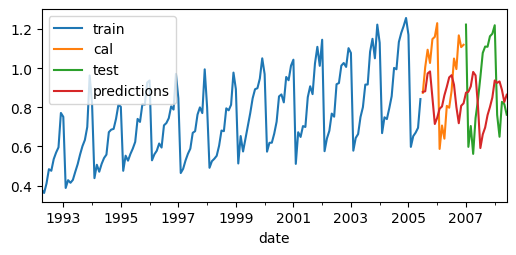

In [8]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_cal['y'].plot(ax=ax, label='cal')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [9]:
non_cp_preds = forecaster.predict(steps=steps)

# Predict with conformal


In [10]:
data_cal['y']


date
2005-07-01    0.874336
2005-08-01    1.006497
2005-09-01    1.094736
2005-10-01    1.027043
2005-11-01    1.149232
2005-12-01    1.160712
2006-01-01    1.230691
2006-02-01    0.587135
2006-03-01    0.706959
2006-04-01    0.639641
2006-05-01    0.807405
2006-06-01    0.797970
2006-07-01    0.884312
2006-08-01    1.049648
2006-09-01    0.995709
2006-10-01    1.168253
2006-11-01    1.108038
2006-12-01    1.120053
Freq: MS, Name: y, dtype: float64

In [18]:
# Calibrate
# ==============================================================================
forecaster.calibrate_conformal(data_cal['y'])


Conformal prediction has been calibrated. The model is now ready to predict conformal intervals.



In [12]:
forecaster.conformal_forecaster.valid_methods_

AttributeError: 'ForecasterAutoreg' object has no attribute 'conformal_forecaster'

In [ ]:
# see estimator
forecaster.conformal_forecaster.estimator

RandomForestRegressor(random_state=123)

In [ ]:
forecaster.conformal_forecaster.method  # this should be aci, I patch it by reassigning 'aci' to it.

'base'

In [ ]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict_conformal_interval(steps=steps, desired_coverage= 0.9, 
                                                    adaptiveness = 'medium')
predictions

(array([0.84512382, 0.86969774, 0.94993832, 0.99308587, 0.97498576,
        0.77606481, 0.62778972, 0.6780842 , 0.78192528, 0.80491055,
        0.78339129, 0.8733837 , 0.89245144, 0.85392715, 0.93893664,
        0.95556637, 0.88605688, 0.83223086, 0.82261021, 0.82732259,
        0.8202242 , 0.82387893, 0.84845665, 0.87916003, 0.89881254,
        0.9393458 , 0.96357991, 0.95525616, 0.69376336, 0.70493242,
        0.79219545, 0.80011589, 0.80332565, 0.84445474, 0.88474805,
        0.82027202]),
 array([[0.72680933, 1.29986033],
        [0.75138325, 1.32443425],
        [0.83162384, 1.40467484],
        [0.87477139, 1.44782239],
        [0.85667127, 1.42972227],
        [0.65775032, 1.23080132],
        [0.50947523, 1.08252623],
        [0.55976971, 1.13282071],
        [0.66361079, 1.23666179],
        [0.68659607, 1.25964707],
        [0.66507681, 1.23812781],
        [0.75506922, 1.32812022],
        [0.77413696, 1.34718796],
        [0.73561267, 1.30866367],
        [0.82062216, 1.393

In [ ]:
preds, y_pis = predictions

In [ ]:
# compare with non cp predictions to see if they are the same
np.isclose(non_cp_preds, preds)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
lower = y_pis[:, 0]
upper = y_pis[:, 1]

lower

array([0.72680933, 0.75138325, 0.83162384, 0.87477139, 0.85667127,
       0.65775032, 0.50947523, 0.55976971, 0.66361079, 0.68659607,
       0.66507681, 0.75506922, 0.77413696, 0.73561267, 0.82062216,
       0.83725188, 0.76774239, 0.71391638, 0.70429573, 0.70900811,
       0.70190971, 0.70556444, 0.73014216, 0.76084555, 0.78049805,
       0.82103131, 0.84526542, 0.83694167, 0.57544888, 0.58661794,
       0.67388097, 0.6818014 , 0.68501116, 0.72614026, 0.76643357,
       0.76121546])

In [ ]:
data_test.index

DatetimeIndex(['2005-07-01', '2005-08-01', '2005-09-01', '2005-10-01',
               '2005-11-01', '2005-12-01', '2006-01-01', '2006-02-01',
               '2006-03-01', '2006-04-01', '2006-05-01', '2006-06-01',
               '2006-07-01', '2006-08-01', '2006-09-01', '2006-10-01',
               '2006-11-01', '2006-12-01', '2007-01-01', '2007-02-01',
               '2007-03-01', '2007-04-01', '2007-05-01', '2007-06-01',
               '2007-07-01', '2007-08-01', '2007-09-01', '2007-10-01',
               '2007-11-01', '2007-12-01', '2008-01-01', '2008-02-01',
               '2008-03-01', '2008-04-01', '2008-05-01', '2008-06-01'],
              dtype='datetime64[ns]', name='date', freq='MS')

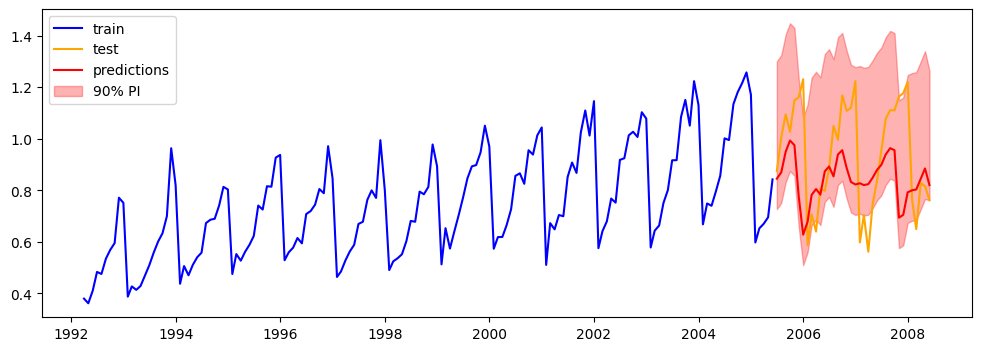

In [ ]:
# visualize predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(data_train.index, data_train['y'], color='blue', label='train')
ax.plot(data_test.index, data_test['y'], color='orange', label='test')
ax.plot(data_test.index, preds, color='red', label='predictions')
ax.fill_between(data_test.index, lower, upper, color='red', alpha=0.3, label='90% PI')
ax.legend();
plt.show()
